In [ ]:
!pip install markovify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 7.7 MB/s 
  Created wheel for markovify: filename=markovify-0.9.4-py3-none-any.whl size=18628 sha256=64beecedcf75ff8f8b7cc2a5ea97bf364a0d0c8f7843a467b2bd7d9ab7450e25
  Stored in directory: /root/.cache/pip/wheels/36/c5/82/11125c5a7dadec27ef49ac2b3a12d3b1f79ff7333c92a9b67b
Successfully built markovify


In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import markovify
from scipy import stats

random_state=11037

In [ ]:
# extracts specified conversation dict

conversation_index_to_explore = 0
with open('result.json') as telegram_data_file:
  telegram_dict = json.load(telegram_data_file)
  conversation_dict = telegram_dict['chats']['list'][conversation_index_to_explore]['messages']

In [ ]:
df = pd.DataFrame(conversation_dict)

In [ ]:
def get_plain_text_from_entities_except_links(text_entities_list):
  text_strings = []
  for text_entity in text_entities_list:
    entity_text = text_entity['text']
    entity_type = text_entity['type']

    if entity_type == 'link':
      entity_text = 'URL'

    text_strings.append(entity_text)
  joined_text = ' '.join(text_strings)
  return joined_text

In [ ]:
df = df.rename({'text': 'raw_text_data'}, axis=1)
df['plain_text'] = df['text_entities'].apply(get_plain_text_from_entities_except_links)
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# feature engineering
df['hour'] = df['date'].dt.hour
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['words_amount'] = df['plain_text'].apply(lambda x: len(x.split()))
df['symbols_amount'] = df['plain_text'].apply(lambda x: len(x))
df['is_weekend'] = df['date'].dt.dayofweek >= 5

In [ ]:
# makes a column with anonymous user number
names = df['from'].unique()
name2idx = {name:i for i, name in enumerate(names)}
df['sent_by'] = df['from'].replace(name2idx)

In [ ]:
df = df[df['type'] != 'service']

In [ ]:
unique_types = set()
for entity_list in list(df['text_entities']):
  for entity in entity_list:
    entity_type = entity['type']
    unique_types = unique_types.union({entity_type})
unique_types

{'bank_card',
 'bold',
 'code',
 'custom_emoji',
 'email',
 'hashtag',
 'italic',
 'link',
 'mention',
 'mention_name',
 'phone',
 'plain',
 'pre',
 'spoiler',
 'strikethrough',
 'text_link',
 'underline'}

# EDA

In [ ]:
df_with_words = df[df['words_amount'] > 0]

todo: look at message size depeding on weekends

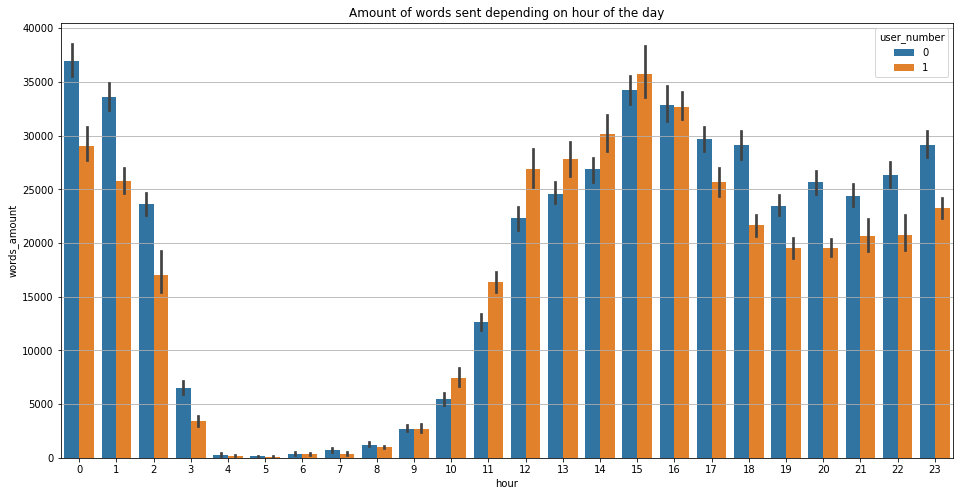

In [ ]:
plt.figure(figsize=(16, 8))
plt.grid(True)
plt.title('Amount of words sent depending on hour of the day')
sns.barplot(x=df_with_words['hour'], y=df_with_words['words_amount'], estimator=np.sum,
            hue=df_with_words['sent_by'])

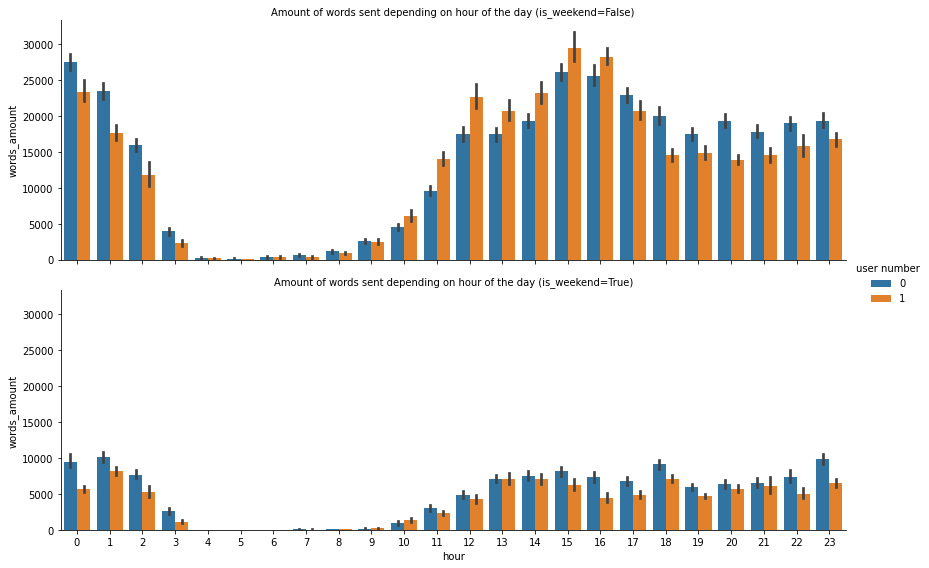

In [ ]:
# lets look with more details. I separated the last plot into business days and weekends
grid = sns.FacetGrid(df_with_words, row="is_weekend", height=4, aspect=3)
grid.map(sns.barplot, "hour", "words_amount",
      hue=df_with_words['sent_by'],
      order=range(0, 24),
      palette=["C0", "C1", "k"],
      estimator=np.sum)
grid.add_legend(title='user number')
grid.set_titles('Amount of words sent depending on hour of the day (is_weekend={row_name})')

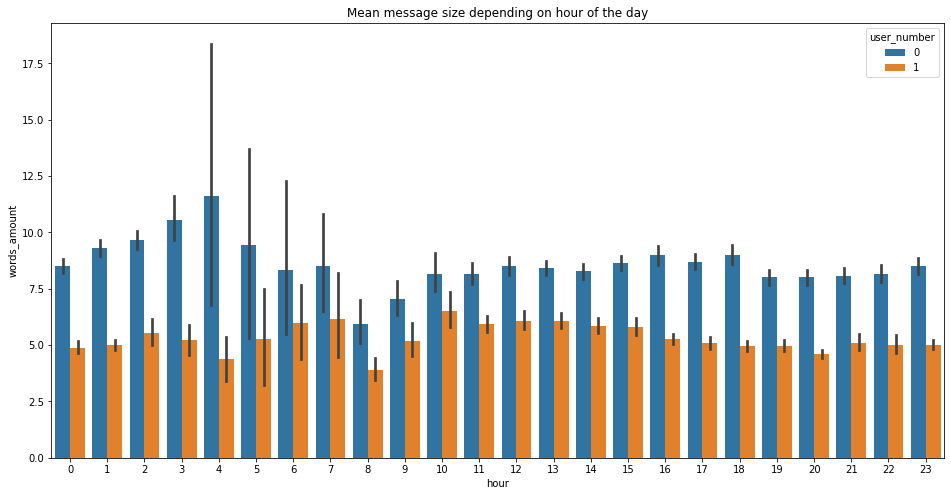

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Mean message size depending on hour of the day')
sns.barplot(x=df_with_words['hour'], y=df_with_words['words_amount'], estimator=np.mean,
            hue=df_with_words['sent_by'])

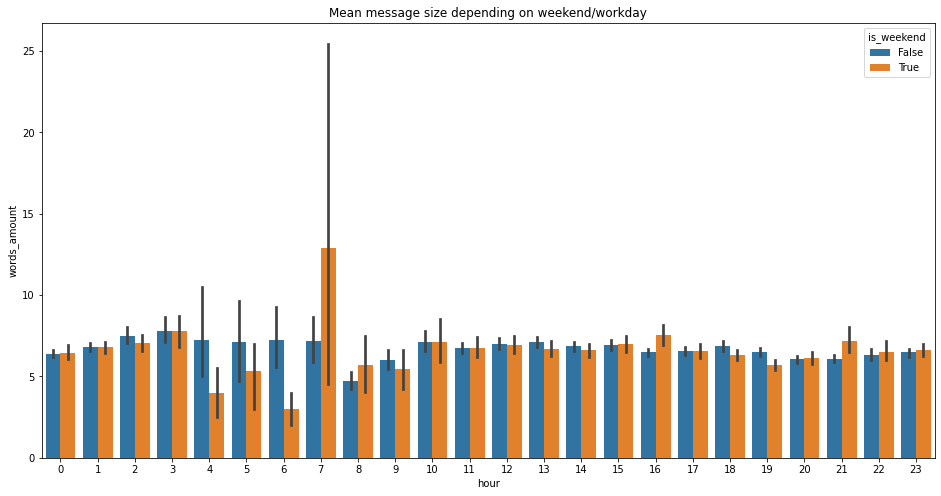

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Mean message size depending on weekend/workday')
sns.barplot(x=df_with_words['hour'], y=df_with_words['words_amount'], estimator=np.mean,
            hue=df_with_words['is_weekend'])

In [ ]:
'''
Computes mean, sum and median of the "values_column_name" column during each day for each user.
Fills in intermediate days with NaN's
'''
def stats_per_day_per_user(dataframe, values_column_name, date_column):
  df_to_work_with = dataframe[[date_column,
                               'sent_by',
                               values_column_name]]

  date_without_time = pd.to_datetime(df_to_work_with[date_column].dt.date)
  stats = df_to_work_with.groupby([date_without_time, 'sent_by']).agg(
    mean_value=(values_column_name, 'mean'),
    sum_value=(values_column_name, 'sum'),
    median_value=(values_column_name, 'median'),
    count_value=(values_column_name, 'count'))

  present_dates = stats.index.levels[0]
  dates_range = pd.date_range(present_dates.min(), present_dates.max())

  stats_with_all_dates = stats.reindex(
    pd.MultiIndex.from_product([dates_range, stats.index.levels[1]],
                               names=['date', 'sent_by']),
                               fill_value=0)
  stats_with_all_dates = stats_with_all_dates.reset_index()
  stats_with_all_dates.columns = stats_with_all_dates.columns.get_level_values(0)

  return stats_with_all_dates

In [ ]:
word_amount_stats = stats_per_day_per_user(df_with_words, 'words_amount', 'date')
word_amount_stats

KeyError: ignored

EXPLAIN WHY REINDEX IS NEEDED

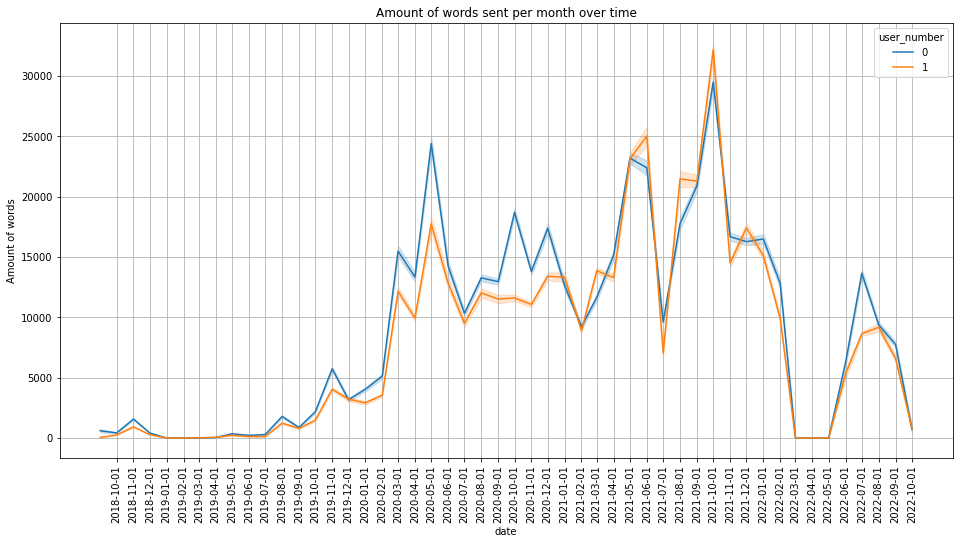

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Amount of words sent per month over time')
plt.xticks(rotation=90)
plt.ylabel('Amount of words')
plt.grid(True)
sns.lineplot(x=pd.to_datetime(word_amount_stats['date'].dt.strftime('%b-%Y')),
             y=word_amount_stats['sum_value'],
             hue=word_amount_stats['sent_by'],
             ci='sd',
             estimator=np.sum)
_ = plt.xticks(pd.date_range(word_amount_stats['date'].min(), word_amount_stats['date'].max(), freq='MS'))

In [ ]:
cutoff_date = pd.to_datetime('2019-08-01')
cutoff_date

Timestamp('2019-08-01 00:00:00')

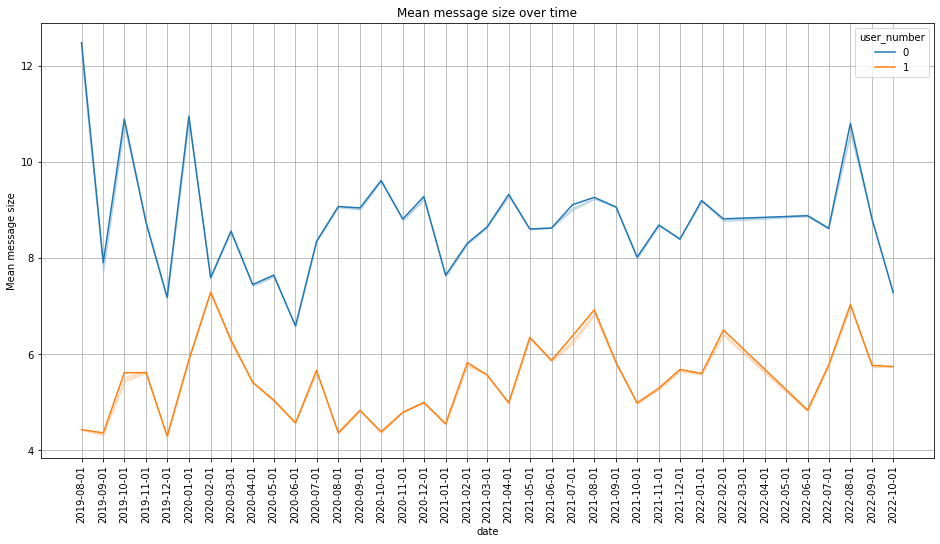

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Mean message size over time')
plt.xticks(rotation=90)
plt.ylabel('Mean message size')
plt.grid(True)

stats_with_date_cutoff = word_amount_stats[word_amount_stats['date'] >= cutoff_date]

# to measure mean message sizes, it is important to only include days when messages were sent.
# To do this, i replace 0's to NaN's
only_positive_word_amounts = stats_with_date_cutoff['mean_value'].replace(0, np.nan)

sns.lineplot(x=pd.to_datetime(stats_with_date_cutoff['date'].dt.strftime('%b-%Y')),
             y=only_positive_word_amounts,
             hue=stats_with_date_cutoff['sent_by'],
             ci=3,
             estimator=np.mean)
_ = plt.xticks(pd.date_range(stats_with_date_cutoff['date'].min(), stats_with_date_cutoff['date'].max(), freq='MS'))

## EDA with response times

### Creating a dataframe with response times

In [ ]:
'''
I want to measure response time for a group of sent messages, and later model
the response time based on data about sent messages

Algorithm to emasure resposne time for a group of messages
0) start recording data about the first user
1) Save message datetime
2) Go through messages continuously:
3)   If next message belongs to the same user - keep joining them together.
4)   If next message belongs to a different user - measure and save response time,
     text of messages, if group contains file/photo, switch to recording
     different user, datetime of their response and go to (2)


Fields:
response_time - time it took for another user to respond to current group since the last message sent in the group

time_took_to_write_group - time elapsed since sending the first message in the group and the last one
time_since_others_messages - time elapsed since other user sent the last message in their group and the first message in current group
last_response_time - time it took for another user to respond to previous sent group since the last message sent in it


date - time when the first message in the group was sent
date_finished - time when the last message in the group was sent
'''

currently_recorded_user = df.iloc[0]['sent_by']
message_group_text_list = []
groups_data = []
current_group_data = dict()
previous_current_user_group_data = dict()
previous_other_user_group_data = dict()

for i, message_row in df.iterrows():
  message_sent_by = message_row['sent_by']

  # if stumbled upon other user - save last group and start reording new group's data
  if message_sent_by != currently_recorded_user:
    current_group_data['text'] = '\n\n'.join(message_group_text_list)
    current_group_data['messages_in_group'] = len(message_group_text_list)
    current_group_data['words_in_group'] = len(current_group_data['text'].split())
    current_group_data['sent_by'] = currently_recorded_user

    current_group_data['time_took_to_write_group'] = current_group_data['date_finished'] - current_group_data['date']
    current_group_data['time_since_others_messages'] = current_group_data['date'] - previous_other_user_group_data.get('date_finished', pd.Timestamp(0))
    current_group_data['last_response_time'] = previous_current_user_group_data.get('response_time', pd.Timestamp(0))

    new_message_date = message_row['date']
    current_group_data['response_time'] = new_message_date - current_group_data['date_finished']

    groups_data.append(current_group_data)

    previous_current_user_group_data = previous_other_user_group_data
    previous_other_user_group_data = current_group_data
    current_group_data = dict()
    message_group_text_list = []

  current_group_data['date'] = current_group_data.get('date', message_row['date'])
  current_group_data['date_finished'] = message_row['date']
  current_group_data['has_file'] = (message_row['file'] is not np.nan) or current_group_data.get('has_file', False)
  current_group_data['has_photo'] = (message_row['photo'] is not np.nan) or current_group_data.get('has_photo', False)

  # records presence of possible media types
  media_type = message_row['media_type']
  possible_media_types = ['voice_message', 'video_file', 'sticker', 'animation', 'video_message', 'audio_file']
  for possible_media_type in possible_media_types:
    key = 'has_' + possible_media_type
    current_group_data[key] = (media_type == possible_media_type) or current_group_data.get(key, False)

  # adds end-of-message punctuation and saves it
  message_text = message_row['plain_text']
  if message_text != '':
    if not message_text.endswith('.'):
      message_text = message_text + '.'
    message_group_text_list.append(message_text)

  currently_recorded_user = message_sent_by

In [ ]:
response_times_df = pd.DataFrame(groups_data)

# removes first 2 message groups as the response time data is incorrect over there,
# fixes the datatype messed up because of incorrect time delta
response_times_df = response_times_df.iloc[2:]
response_times_df['last_response_time'] = response_times_df['last_response_time'].astype('timedelta64[ns]')

In [ ]:
# converts time values to minutes

time_columns = ['response_time',
               'time_took_to_write_group',
               'time_since_others_messages',
               'last_response_time']
for column in time_columns:
  response_times_df[column] = response_times_df[column].dt.total_seconds()

In [ ]:
response_times_df['hour_finished'] = response_times_df['date'].dt.hour
response_times_df['month_finished'] = response_times_df['date'].dt.month
response_times_df['date_finished_without_time'] = pd.to_datetime(response_times_df['date_finished'].dt.date)
response_times_df['finished_on_weekend'] = response_times_df['date'].dt.dayofweek >= 5

In [ ]:
response_times_df

,date,date_finished,has_file,has_photo,has_voice_message,has_video_file,has_sticker,has_animation,has_video_message,has_audio_file,...,words_in_group,sent_by,time_took_to_write_group,time_since_others_messages,last_response_time,response_time,hour_finished,month_finished,date_finished_without_time,finished_on_weekend
2,2018-09-28 16:24:12,2018-09-28 16:24:12,False,False,False,False,False,False,False,False,...,8,0,0.0,2850.0,13.0,78.0,16,9,2018-09-28,False
3,2018-09-28 16:25:30,2018-09-28 16:25:30,False,False,False,False,False,False,False,False,...,1,1,0.0,78.0,2850.0,579.0,16,9,2018-09-28,False
4,2018-09-28 16:35:09,2018-09-28 16:35:09,False,False,False,False,False,False,False,False,...,2,0,0.0,579.0,78.0,135.0,16,9,2018-09-28,False
5,2018-09-28 16:37:24,2018-09-28 16:37:24,False,False,False,False,False,False,False,False,...,1,1,0.0,135.0,579.0,1335.0,16,9,2018-09-28,False
6,2018-09-28 16:59:39,2018-09-28 16:59:43,True,False,False,False,False,False,False,False,...,3,0,4.0,1335.0,135.0,2.0,16,9,2018-09-28,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56758,2022-10-03 21:13:04,2022-10-04 08:32:44,False,False,False,False,False,False,False,False,...,12,0,40780.0,19.0,67.0,3409.0,21,10,2022-10-04,False
56759,2022-10-04 09:29:33,2022-10-04 09:29:33,False,False,False,False,False,False,False,False,...,1,1,0.0,3409.0,19.0,7091.0,9,10,2022-10-04,False
56760,2022-10-04 11:27:44,2022-10-04 11:27:51,False,False,False,False,False,False,False,False,...,9,0,7.0,7091.0,3409.0,2272.0,11,10,2022-10-04,False
56761,2022-10-04 12:05:43,2022-10-04 13:48:16,False,True,False,False,False,False,False,False,...,25,1,6153.0,2272.0,7091.0,421.0,12,10,2022-10-04,False


### Analyzing the response times

In [ ]:
description = response_times_df.describe()
description.T

,count,mean,std,min,25%,50%,75%,max
messages_in_group,56761.0,2.280739,2.424270,0.0,1.0,1.0,3.0,67.0
words_in_group,56761.0,15.187999,26.187632,0.0,3.0,8.0,18.0,1462.0
sent_by,56761.0,0.499991,0.500004,0.0,0.0,0.0,1.0,1.0
time_took_to_write_group,56761.0,1211.285020,43635.883690,0.0,0.0,3.0,36.0,9709194.0
time_since_others_messages,56761.0,1021.881873,25820.114497,0.0,7.0,21.0,84.0,5584413.0
last_response_time,56761.0,1021.874685,25820.114721,0.0,7.0,21.0,84.0,5584413.0
response_time,56761.0,1021.852452,25820.113365,0.0,7.0,21.0,84.0,5584413.0
hour_finished,56761.0,13.563979,7.286793,0.0,11.0,15.0,19.0,23.0
month_finished,56761.0,6.893642,3.319749,1.0,4.0,7.0,10.0,12.0


Maximum response time is much larger than common values, it is nevessary to filter outliers. This will clear out meaningless response times of several months

In [ ]:
outliers_filter = (np.abs(stats.zscore(response_times_df[time_columns])) < 3).all(axis=1)
response_times_without_outliers = response_times_df[outliers_filter]
print(f'Portion of records retained: {outliers_filter.mean()}')
response_times_without_outliers.describe().T

Portion of records retained: 0.9973397226969222


,count,mean,std,min,25%,50%,75%,max
messages_in_group,56610.0,2.280392,2.424497,0.0,1.0,1.0,3.0,67.0
words_in_group,56610.0,15.183148,26.178043,0.0,3.0,8.0,18.0,1462.0
sent_by,56610.0,0.499823,0.500004,0.0,0.0,0.0,1.0,1.0
time_took_to_write_group,56610.0,775.544939,5008.055412,0.0,0.0,3.0,36.0,125510.0
time_since_others_messages,56610.0,733.378272,3897.556069,0.0,7.0,21.0,83.0,76336.0
last_response_time,56610.0,730.947995,3884.980553,0.0,7.0,21.0,83.0,76336.0
response_time,56610.0,732.667303,3896.606706,0.0,7.0,21.0,83.0,76336.0
hour_finished,56610.0,13.561332,7.290595,0.0,11.0,15.0,19.0,23.0
month_finished,56610.0,6.889896,3.318706,1.0,4.0,7.0,10.0,12.0


Distribution looks normal only on log scale, this indicated that it is still unbalanced

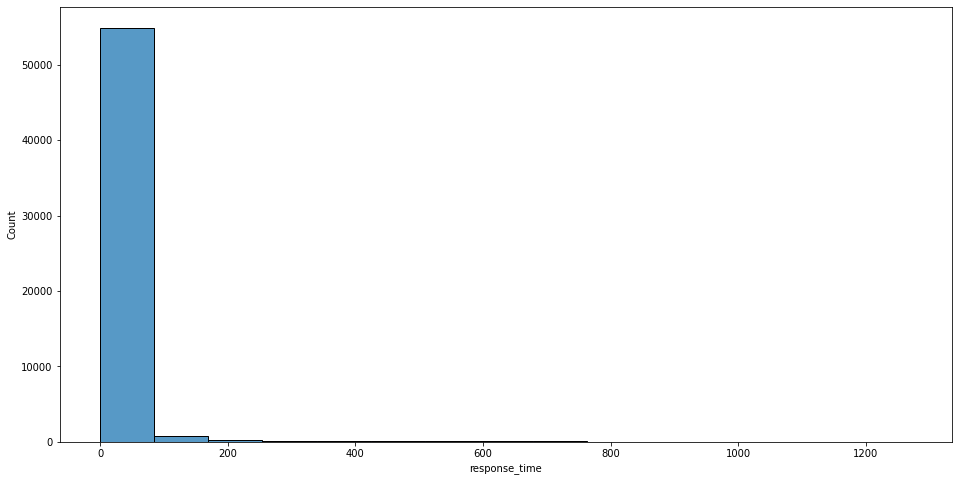

In [ ]:
plt.figure(figsize=(16, 8))
sns.histplot(x=response_times_without_outliers['response_time'] / 60,
             bins=15)

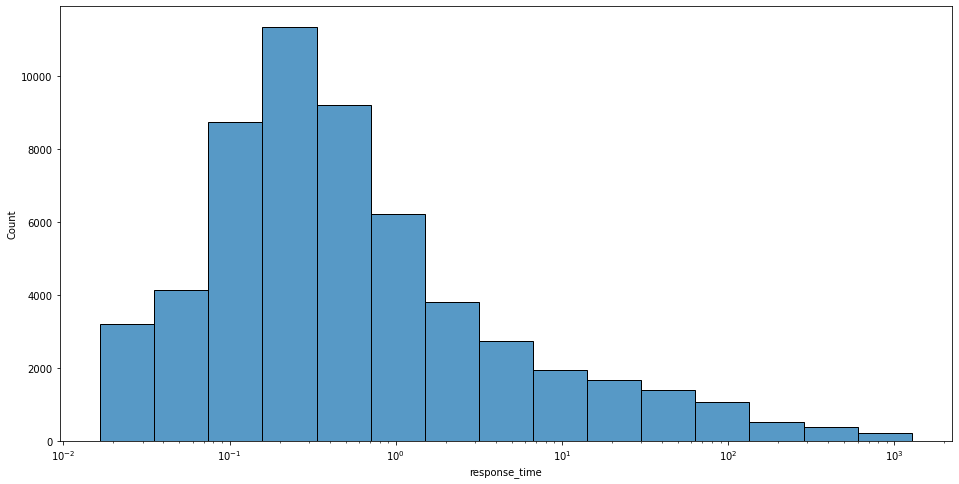

In [ ]:
plt.figure(figsize=(16, 8))
sns.histplot(x=(response_times_without_outliers['response_time']+1) / 60,
             log_scale=True,
             bins=15)

Response times larger than 5 minutes can be in their own category, "long response time"

In [ ]:
long_response_time = 5 * 60
is_long_response_time = response_times_without_outliers['response_time'] > long_response_time
response_times_without_outliers['is_long_response_time'] = is_long_response_time
print(f'Fraction of long response times: {is_long_response_time.mean()} \
({is_long_response_time.sum()} out of {len(response_times_without_outliers)})')

Fraction of long response times: 0.14361420243773185 (8130 out of 56610)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


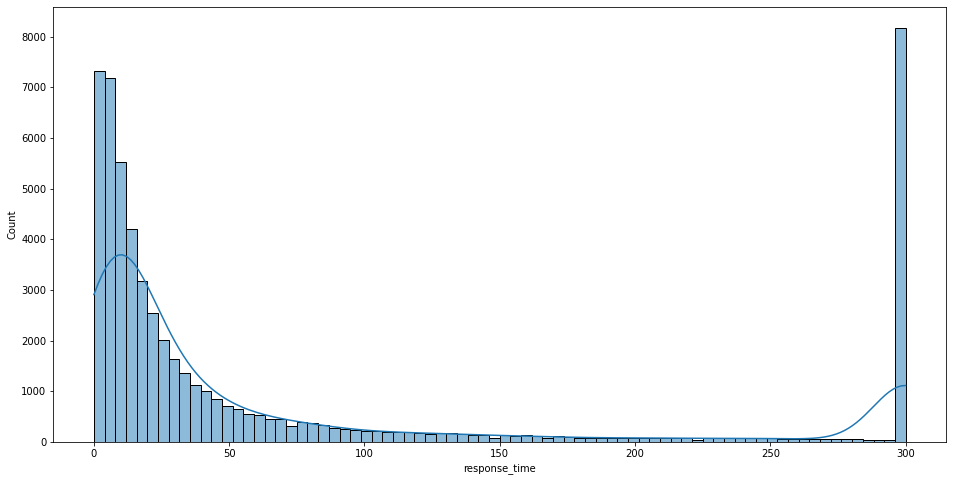

In [ ]:
plt.figure(figsize=(16, 8))
sns.histplot(x=np.clip(response_times_without_outliers['response_time'], 0, long_response_time),
             kde=True)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 <a list of 19 Text major ticklabel objects>)

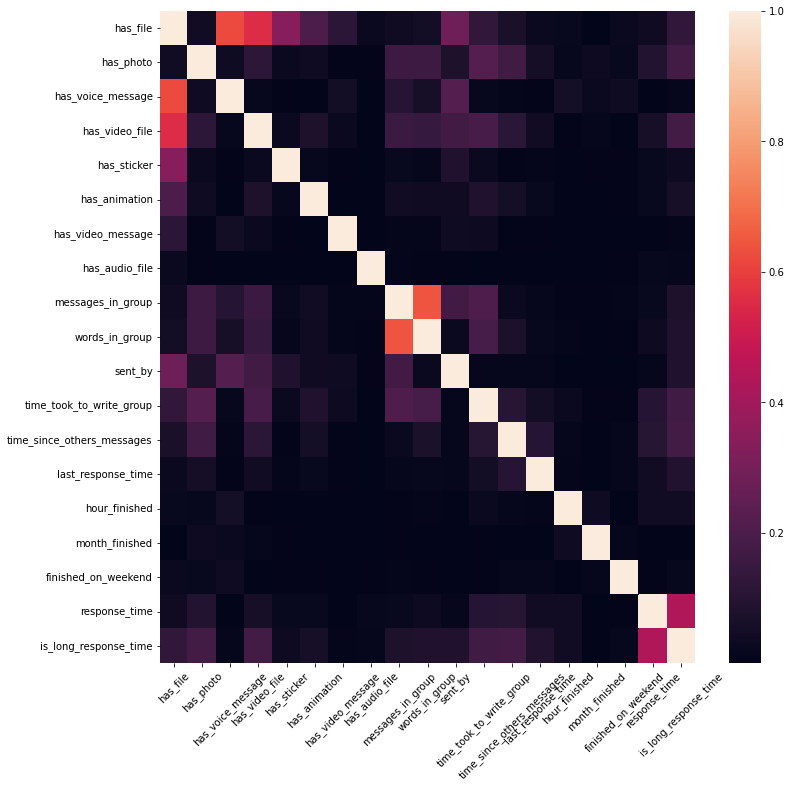

In [ ]:
columns_for_correlation = ['has_file', 'has_photo', 'has_voice_message',
'has_video_file', 'has_sticker', 'has_animation', 'has_video_message',
'has_audio_file', 'messages_in_group', 'words_in_group',
'sent_by', 'time_took_to_write_group', 'time_since_others_messages',
'last_response_time', 'hour_finished', 'month_finished',
'finished_on_weekend', 'response_time', 'is_long_response_time']

plt.figure(figsize=(12, 12))
sns.heatmap(response_times_without_outliers[columns_for_correlation].corr().abs())
plt.xticks(rotation=45)

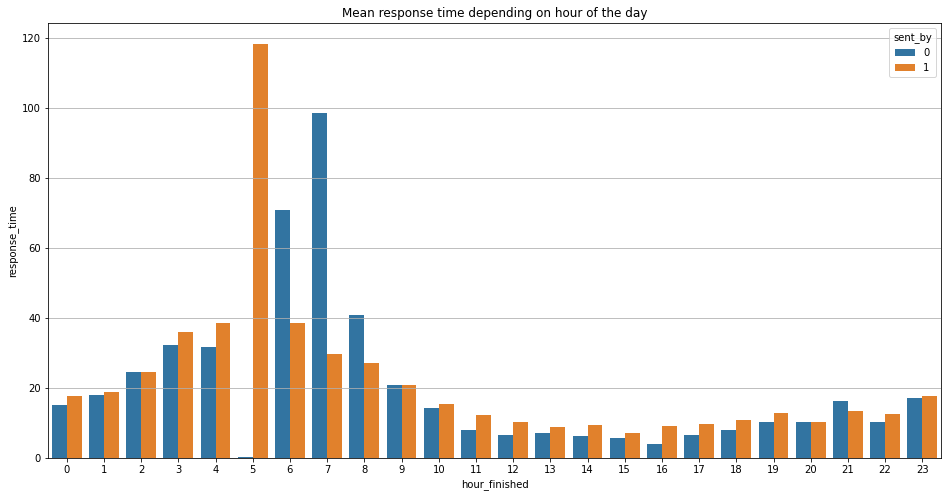

In [ ]:
# todo: exclude low-volume hours

plt.figure(figsize=(16, 8))
plt.grid(True)
plt.title('Mean response time depending on hour of the day')
sns.barplot(x=response_times_without_outliers['hour_finished'],
            y=response_times_without_outliers['response_time'] / 60,
            estimator=np.mean,
            hue=response_times_without_outliers['sent_by'],
            ci=None)

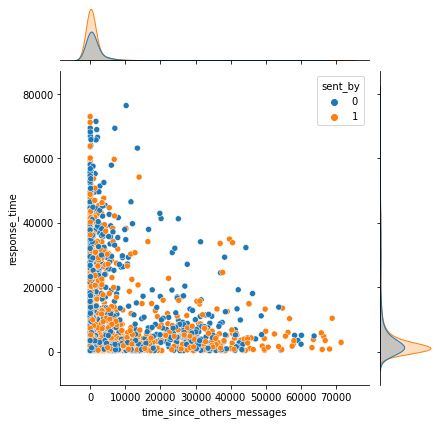

In [ ]:
sns.jointplot(data=response_times_without_outliers[is_long_response_time],
              x="time_since_others_messages",
              y="response_time",
              hue="sent_by")

In [ ]:
response_time_stats_per_day = stats_per_day_per_user(response_times_without_outliers, 'response_time', 'date_finished')

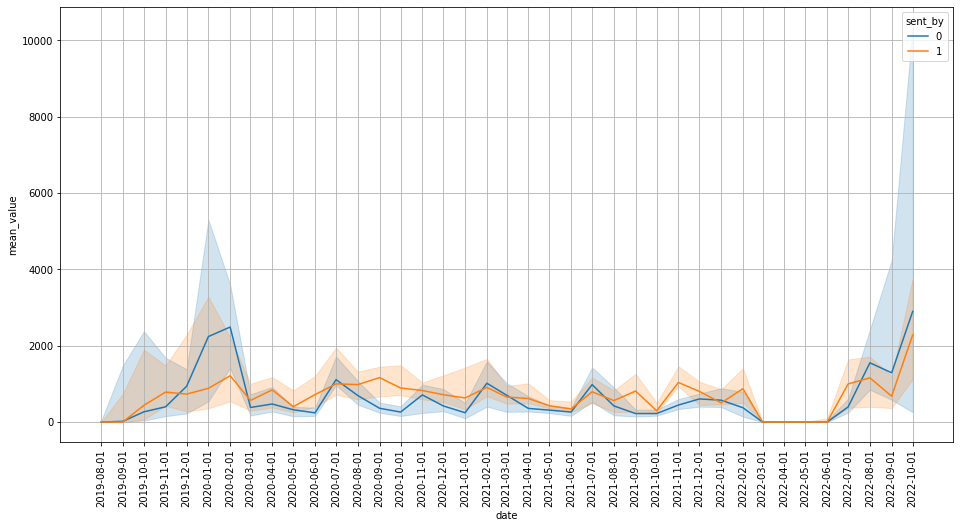

In [ ]:
plt.figure(figsize=(16, 8))
plt.grid(True)
plt.xticks(rotation=90)

response_time_stats_per_day = response_time_stats_per_day[response_time_stats_per_day['date'] >= cutoff_date]
#todo: remove 0's

sns.lineplot(x=pd.to_datetime(response_time_stats_per_day['date'].dt.strftime('%b-%Y')),
             y=response_time_stats_per_day['mean_value'],
             hue=response_time_stats_per_day['sent_by'],
             estimator=np.median)
_ = plt.xticks(pd.date_range(response_time_stats_per_day['date'].min(), response_time_stats_per_day['date'].max(), freq='MS'))

# Modeling response time

First of all, I will be modelling response times based only on non-textual static data about sent message group

In [ ]:
dataset_df = response_times_without_outliers.copy()
print(f'Dataset size: {len(dataset_df)}')

Dataset size: 56610


In [ ]:
columns_to_exclude_from_features = ['date', 'date_finished', 'date_finished_without_time', 'response_time', 'text', 'is_long_response_time']
standard_features_columns = [column for column in dataset_df.columns if column not in columns_to_exclude_from_features]
standard_features_columns

['has_file',
 'has_photo',
 'has_voice_message',
 'has_video_file',
 'has_sticker',
 'has_animation',
 'has_video_message',
 'has_audio_file',
 'messages_in_group',
 'words_in_group',
 'sent_by',
 'time_took_to_write_group',
 'time_since_others_messages',
 'last_response_time',
 'hour_finished',
 'month_finished',
 'finished_on_weekend']

In [ ]:
dataset_df.dtypes

date                          datetime64[ns]
date_finished                 datetime64[ns]
has_file                                bool
has_photo                               bool
has_voice_message                       bool
has_video_file                          bool
has_sticker                             bool
has_animation                           bool
has_video_message                       bool
has_audio_file                          bool
text                                  object
messages_in_group                      int64
words_in_group                         int64
sent_by                                int64
time_took_to_write_group             float64
time_since_others_messages           float64
last_response_time                   float64
response_time                        float64
hour_finished                          int64
month_finished                         int64
date_finished_without_time    datetime64[ns]
finished_on_weekend                     bool
is_long_re

In [ ]:
# todo: describe why "sent_by" is used as boolean
dataset_df['sent_by'] = dataset_df['sent_by'].astype(bool)

In [ ]:
# standartizing numeric and bool columns datatype to float

numeric_features = list(dataset_df[standard_features_columns].select_dtypes('number').columns)
boolean_features = list(dataset_df[standard_features_columns].select_dtypes('bool').columns)
target_column = 'is_long_response_time'

for column in numeric_features + boolean_features:
  dataset_df[column] = dataset_df[column].astype(float)
dataset_df[target_column] = dataset_df[target_column].astype(float)

dataset_df.dtypes

date                          datetime64[ns]
date_finished                 datetime64[ns]
has_file                             float64
has_photo                            float64
has_voice_message                    float64
has_video_file                       float64
has_sticker                          float64
has_animation                        float64
has_video_message                    float64
has_audio_file                       float64
text                                  object
messages_in_group                    float64
words_in_group                       float64
sent_by                              float64
time_took_to_write_group             float64
time_since_others_messages           float64
last_response_time                   float64
response_time                        float64
hour_finished                        float64
month_finished                       float64
date_finished_without_time    datetime64[ns]
finished_on_weekend                  float64
is_long_re

In [ ]:
from sklearn.model_selection import train_test_split

X = dataset_df[standard_features_columns]
y = dataset_df[[target_column]]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.3, random_state=11037)
y_train = y_train.values.ravel()
y_valid = y_valid.values.ravel()
print(f'Train size: {len(X_train)}')
print(f'Validation size: {len(X_valid)}')

Train size: 39627
Validation size: 16983


Performing resampleing of unbalanced dataset, as long response times are in the minority

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN

X_train_SMOTE, y_train_SMOTE = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
X_train_ADASYN, y_train_ADASYN = ADASYN(random_state=random_state).fit_resample(X_train, y_train)

print(f'Proportion of positive classes: {y_train.mean()}')
print(f'Proportion of positive classes with SMOTE: {y_train_SMOTE.mean()}')
print(f'Proportion of positive classes with ADASYN: {y_train_ADASYN.mean()}')

Proportion of positive classes: 0.14305902541196658
Proportion of positive classes with SMOTE: 0.5
Proportion of positive classes with ADASYN: 0.5068759711310864


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

numerical_pipeline = Pipeline(steps=[
    ('standard_scaler', StandardScaler())
])

scale_numeric_only = ColumnTransformer(transformers=[
    ('numerical_scaler', numerical_pipeline, numeric_features),
], remainder='passthrough')

all_standard_data_preprocessor = Pipeline(steps=[
    ('scale_numeric_only', scale_numeric_only),
])

In [ ]:
def create_model_pipeline(model):
  pipeline = Pipeline(steps=[
    ('preprocess', all_standard_data_preprocessor),
    ('model', model)
  ])
  return pipeline

Testing data original
Testing model forest


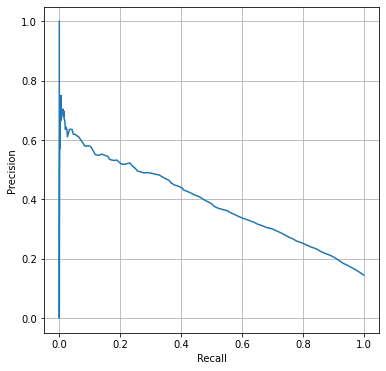

ROC AUC score: 0.589751269788035
Precision-Recall AUC score: 0.3907996730080504
Accuracy (treshold 0.3): 0.8260024730612966
Recall (treshold 0.3): 0.4575375863470134
Precision (treshold 0.3): 0.41005098324836126
Accuracy (treshold 0.5): 0.8581522699169758
Recall (treshold 0.5): 0.17960178789110118
Precision (treshold 0.5): 0.53125
Accuracy (treshold 0.7): 0.8566213272095625
Recall (treshold 0.7): 0.02478667208451849
Precision (treshold 0.7): 0.6354166666666666


Testing model linear


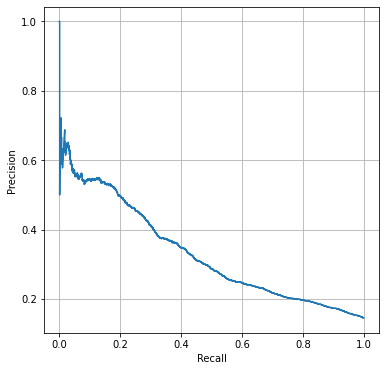

ROC AUC score: 0.5111882678698312
Precision-Recall AUC score: 0.33132963542352245
Accuracy (treshold 0.3): 0.8530295000883236
Recall (treshold 0.3): 0.2133279154815116
Precision (treshold 0.3): 0.4838709677419355
Accuracy (treshold 0.5): 0.8575045633869163
Recall (treshold 0.5): 0.1003657049979683
Precision (treshold 0.5): 0.5452538631346578
Accuracy (treshold 0.7): 0.8569157392686805
Recall (treshold 0.7): 0.03819585534335636
Precision (treshold 0.7): 0.5987261146496815


Testing model gaussian


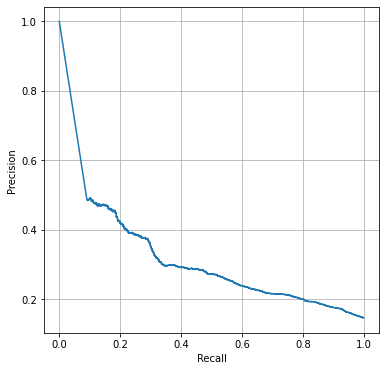

ROC AUC score: 0.5169288049613077
Precision-Recall AUC score: 0.3202990366658433
Accuracy (treshold 0.3): 0.8325384207737149
Recall (treshold 0.3): 0.259650548557497
Precision (treshold 0.3): 0.3847080072245635
Accuracy (treshold 0.5): 0.8333627745392451
Recall (treshold 0.5): 0.2535554652580252
Precision (treshold 0.5): 0.38589981447124305
Accuracy (treshold 0.7): 0.8338338338338338
Recall (treshold 0.7): 0.24908573750507923
Precision (treshold 0.7): 0.38626339004410837


Testing model QDA


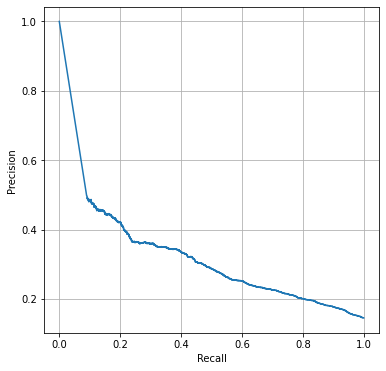

ROC AUC score: 0.5910075430398278
Precision-Recall AUC score: 0.3270275287554222
Accuracy (treshold 0.3): 0.825943590649473
Recall (treshold 0.3): 0.26290125965054856
Precision (treshold 0.3): 0.3616545556176635
Accuracy (treshold 0.5): 0.826944591650474
Recall (treshold 0.5): 0.2592442096708655
Precision (treshold 0.5): 0.3637400228050171
Accuracy (treshold 0.7): 0.8273567685332391
Recall (treshold 0.7): 0.255180820804551
Precision (treshold 0.7): 0.36363636363636365


Testing model AdaBoostClassifier


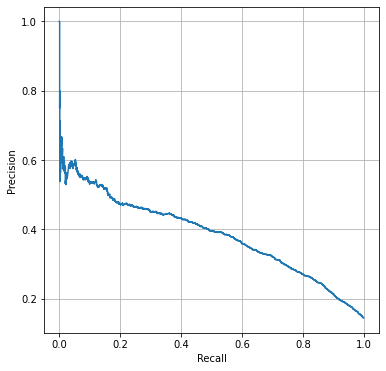

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC score: 0.589751269788035
Precision-Recall AUC score: 0.38562940010341834
Accuracy (treshold 0.3): 0.14490961549785078
Recall (treshold 0.3): 1.0
Precision (treshold 0.3): 0.14490961549785078
Accuracy (treshold 0.5): 0.8567979744450333
Recall (treshold 0.5): 0.1548151158065827
Precision (treshold 0.5): 0.519781718963165
Accuracy (treshold 0.7): 0.8550903845021492
Recall (treshold 0.7): 0.0
Precision (treshold 0.7): 0.0








Testing data SMOTE
Testing model forest


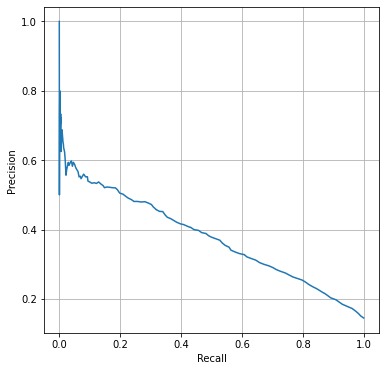

ROC AUC score: 0.5
Precision-Recall AUC score: 0.37720337999564846
Accuracy (treshold 0.3): 0.8048048048048048
Recall (treshold 0.3): 0.5132060138155221
Precision (treshold 0.3): 0.3736686390532544
Accuracy (treshold 0.5): 0.8531472649119708
Recall (treshold 0.5): 0.23689557090613572
Precision (treshold 0.5): 0.48623853211009177
Accuracy (treshold 0.7): 0.8572101513277984
Recall (treshold 0.7): 0.061357171881349044
Precision (treshold 0.7): 0.5676691729323309


Testing model linear


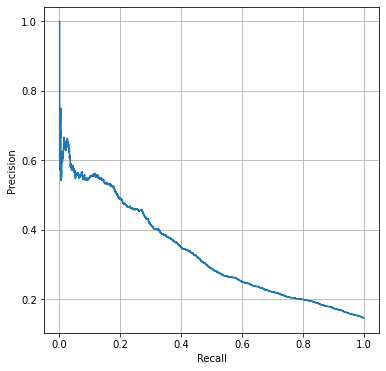

ROC AUC score: 0.5267190762312681
Precision-Recall AUC score: 0.33409677310170793
Accuracy (treshold 0.3): 0.2713301536830949
Recall (treshold 0.3): 0.9471759447379114
Precision (treshold 0.3): 0.1599204171240395
Accuracy (treshold 0.5): 0.7368545015603839
Recall (treshold 0.5): 0.5156440471353109
Precision (treshold 0.5): 0.2791465024197096
Accuracy (treshold 0.7): 0.8475534357887299
Recall (treshold 0.7): 0.2706216984965461
Precision (treshold 0.7): 0.45616438356164385


Testing model gaussian


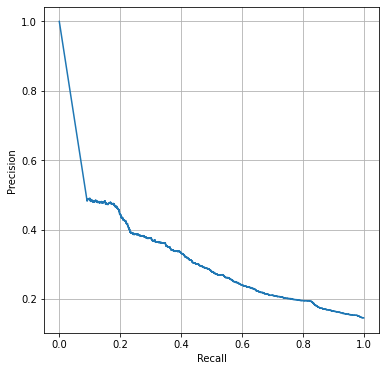

ROC AUC score: 0.6079730169937626
Precision-Recall AUC score: 0.326864404496047
Accuracy (treshold 0.3): 0.8301831243007713
Recall (treshold 0.3): 0.2771231206826493
Precision (treshold 0.3): 0.38164521544487967
Accuracy (treshold 0.5): 0.8313607725372432
Recall (treshold 0.5): 0.26615197074360014
Precision (treshold 0.5): 0.38237011091652073
Accuracy (treshold 0.7): 0.8326561855973621
Recall (treshold 0.7): 0.2592442096708655
Precision (treshold 0.7): 0.38503319251659623


Testing model QDA


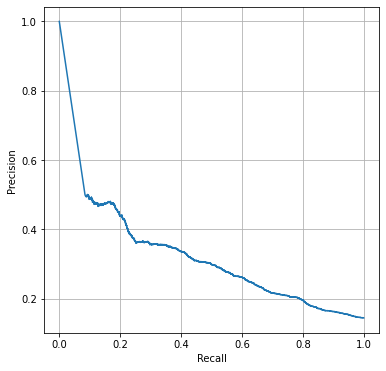

ROC AUC score: 0.5945374057581706
Precision-Recall AUC score: 0.328729765723057
Accuracy (treshold 0.3): 0.8255314137667079
Recall (treshold 0.3): 0.275904104022755
Precision (treshold 0.3): 0.3650537634408602
Accuracy (treshold 0.5): 0.8264146499440617
Recall (treshold 0.5): 0.26655830963023164
Precision (treshold 0.5): 0.36464702612562533
Accuracy (treshold 0.7): 0.8267679444150032
Recall (treshold 0.7): 0.2600568874441284
Precision (treshold 0.7): 0.3634298693923907


Testing model AdaBoostClassifier


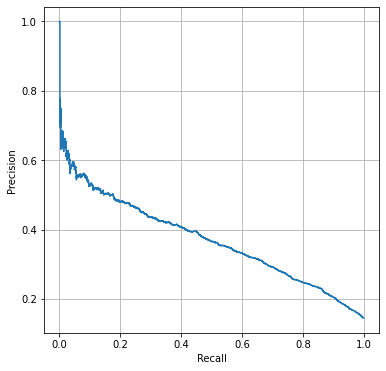

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC score: 0.5914318316851547
Precision-Recall AUC score: 0.37098296312741447
Accuracy (treshold 0.3): 0.14490961549785078
Recall (treshold 0.3): 1.0
Precision (treshold 0.3): 0.14490961549785078
Accuracy (treshold 0.5): 0.8463757875522582
Recall (treshold 0.5): 0.27346607070296625
Precision (treshold 0.5): 0.4504685408299866
Accuracy (treshold 0.7): 0.8550903845021492
Recall (treshold 0.7): 0.0
Precision (treshold 0.7): 0.0








Testing data ADASYN
Testing model forest


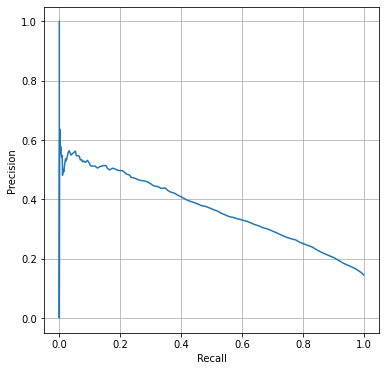

ROC AUC score: 0.5
Precision-Recall AUC score: 0.3674107483780507
Accuracy (treshold 0.3): 0.8021550962727433
Recall (treshold 0.3): 0.5030475416497359
Precision (treshold 0.3): 0.3668148148148148
Accuracy (treshold 0.5): 0.8532061473237944
Recall (treshold 0.5): 0.22023567655424625
Precision (treshold 0.5): 0.48566308243727596
Accuracy (treshold 0.7): 0.8567979744450333
Recall (treshold 0.7): 0.05282405526208858
Precision (treshold 0.7): 0.5627705627705628


Testing model linear


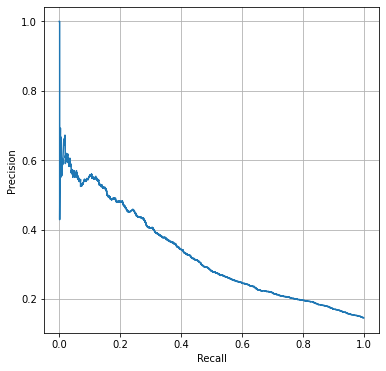

ROC AUC score: 0.5229345451906091
Precision-Recall AUC score: 0.3262460917471074
Accuracy (treshold 0.3): 0.21815933580639463
Recall (treshold 0.3): 0.9691182446160097
Precision (treshold 0.3): 0.15301212548918972
Accuracy (treshold 0.5): 0.6695519048460224
Recall (treshold 0.5): 0.6103210077204388
Precision (treshold 0.5): 0.24402924451665312
Accuracy (treshold 0.7): 0.8443737855502561
Recall (treshold 0.7): 0.2572125152377083
Precision (treshold 0.7): 0.43715469613259667


Testing model gaussian


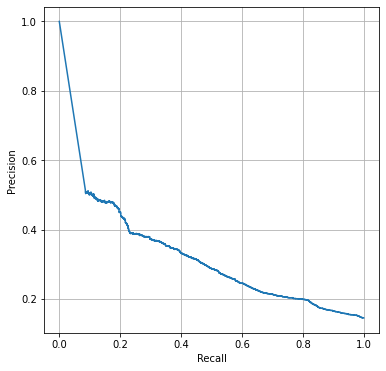

ROC AUC score: 0.6005453844608869
Precision-Recall AUC score: 0.32977136178464983
Accuracy (treshold 0.3): 0.8294765353588883
Recall (treshold 0.3): 0.2803738317757009
Precision (treshold 0.3): 0.38016528925619836
Accuracy (treshold 0.5): 0.8316551845963611
Recall (treshold 0.5): 0.26777732629012596
Precision (treshold 0.5): 0.38403263403263405
Accuracy (treshold 0.7): 0.8327150680091857
Recall (treshold 0.7): 0.26046322633075986
Precision (treshold 0.7): 0.38567990373044525


Testing model QDA


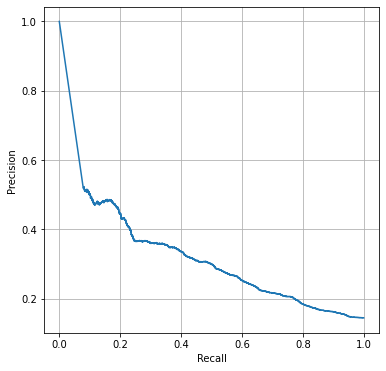

ROC AUC score: 0.5950780530496934
Precision-Recall AUC score: 0.32739200983389866
Accuracy (treshold 0.3): 0.8255902961785315
Recall (treshold 0.3): 0.275904104022755
Precision (treshold 0.3): 0.3652501344809037
Accuracy (treshold 0.5): 0.826944591650474
Recall (treshold 0.5): 0.2669646485168631
Precision (treshold 0.5): 0.3666294642857143
Accuracy (treshold 0.7): 0.8276511805923571
Recall (treshold 0.7): 0.25883787078423404
Precision (treshold 0.7): 0.3660919540229885


Testing model AdaBoostClassifier


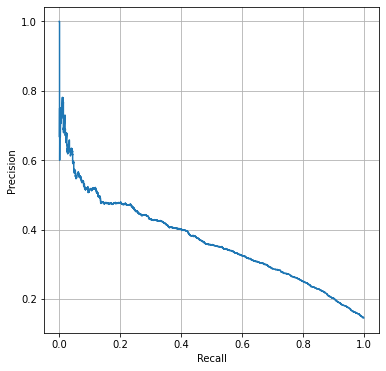

ROC AUC score: 0.5914420727010277
Precision-Recall AUC score: 0.3662782183294336
Accuracy (treshold 0.3): 0.14490961549785078
Recall (treshold 0.3): 1.0
Precision (treshold 0.3): 0.14490961549785078
Accuracy (treshold 0.5): 0.8454336689630807
Recall (treshold 0.5): 0.2673709874034945
Precision (treshold 0.5): 0.4445945945945946
Accuracy (treshold 0.7): 0.8550903845021492
Recall (treshold 0.7): 0.0
Precision (treshold 0.7): 0.0










/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc

X_train_to_use = X_train
y_train_to_use = y_train
data_to_try = {
    'original': (X_train, y_train),
    'SMOTE': (X_train_SMOTE, y_train_SMOTE),
    'ADASYN': (X_train_ADASYN, y_train_ADASYN)
}

results_for_df = []
for data_name, (X_train_to_use, y_train_to_use) in data_to_try.items():
  print(f'Testing data {data_name}')

  models = {
  'forest': RandomForestClassifier(128),
  'linear': LogisticRegression(max_iter=10000),
  'gaussian': GaussianNB(),
  'QDA': QuadraticDiscriminantAnalysis(),
  'AdaBoostClassifier': AdaBoostClassifier(n_estimators=128)
  }

  for model_name, model in models.items():
    print(f'Testing model {model_name}')
    pipeline = create_model_pipeline(model)
    pipeline.fit(X_train_to_use, y_train_to_use)

    predicted_probas = pipeline.predict_proba(X_valid)[:, 1]
    precisions, recalls, _ = precision_recall_curve(y_valid, predicted_probas)
    plt.figure(figsize=(6, 6))
    plt.plot(recalls, precisions)
    plt.grid(True)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

    results_dict = {
        'ROC AUC score': roc_auc_score(y_valid, preds_binary),
        'Precision-Recall AUC score': auc(recalls, precisions),
    }
    tresholds_to_try = [0.3, 0.5, 0.7]
    for treshold in tresholds_to_try:
      preds_binary = predicted_probas > treshold
      results_dict[f'Accuracy (treshold {treshold})'] = accuracy_score(y_valid, preds_binary)
      results_dict[f'Recall (treshold {treshold})'] = recall_score(y_valid, preds_binary)
      results_dict[f'Precision (treshold {treshold})'] = precision_score(y_valid, preds_binary)

    for metric, score in results_dict.items():
      print(f'{metric}: {score}')
    results_dict['Data version'] = data_name
    results_dict['Model'] = model_name
    results_for_df.append(results_dict)
    print('\n' + '='*50 + '\n')
  print('\n\n\n' + '='*50 + '\n\n\n')

In [ ]:
results_df = pd.DataFrame(results_for_df)
for metric in ['ROC AUC score', 'Precision-Recall AUC score']:
  print(f'Top-list for metric {metric}')
  display(results_df.sort_values(metric, ascending=False)[['Model', 'Data version', metric]])
  print()

Top-list for metric ROC AUC score


,Model,Data version,ROC AUC score
7,gaussian,SMOTE,0.607973
12,gaussian,ADASYN,0.600545
13,QDA,ADASYN,0.595078
8,QDA,SMOTE,0.594537
14,AdaBoostClassifier,ADASYN,0.591442
9,AdaBoostClassifier,SMOTE,0.591432
3,QDA,original,0.591008
0,forest,original,0.589751
4,AdaBoostClassifier,original,0.589751
6,linear,SMOTE,0.526719



Top-list for metric Precision-Recall AUC score


,Model,Data version,Precision-Recall AUC score
0,forest,original,0.390800
4,AdaBoostClassifier,original,0.385629
5,forest,SMOTE,0.377203
9,AdaBoostClassifier,SMOTE,0.370983
10,forest,ADASYN,0.367411
14,AdaBoostClassifier,ADASYN,0.366278
6,linear,SMOTE,0.334097
1,linear,original,0.331330
12,gaussian,ADASYN,0.329771
8,QDA,SMOTE,0.328730


In [ ]:
standard_features_columns

['has_file',
 'has_photo',
 'has_voice_message',
 'has_video_file',
 'has_sticker',
 'has_animation',
 'has_video_message',
 'has_audio_file',
 'messages_in_group',
 'words_in_group',
 'sent_by',
 'time_took_to_write_group',
 'time_since_others_messages',
 'last_response_time',
 'hour_finished',
 'month_finished',
 'finished_on_weekend']

In [ ]:
input_standard_data = {
    'has_file': 0.0,
    'has_photo': 0.0,
    'has_voice_message': 0.0,
    'has_video_file': 0.0,
    'has_sticker': 0.0,
    'has_animation': 0.0,
    'has_video_message': 0.0,
    'has_audio_file': 0.0,
    'messages_in_group': 1,
    'words_in_group': 1,
    'sent_by': 0.0,
    'time_took_to_write_group': 0.0,
    'time_since_others_messages': 10260,
    'last_response_time': 360,
    'hour_finished': 16,
    'month_finished': 10.0,
    'finished_on_weekend': 0.0
}

inference_df = pd.DataFrame([input_standard_data])
inference_pred = svr_standard_pipeline.predict(inference_df)
inference_true_result = target_data_pipeline.inverse_transform(inference_pred.reshape(1, -1))
inference_true_result
#inference_pred

array([[462.25669832]])

# Generating text with Markov chains

In [ ]:
# AAAAAAAAAAAA
# try using any keyword as a shtsartttt
# and fit all text in one line and use new line generagtor so that it onlyknows 1 sentence

In [ ]:
'''
Turns text "a" sent by user 1 into text "User1: a."
'''
def create_message_prefix_and_suffix(message_entry):
  suffix = ''
  if not message_entry['text'].endswith('.'):
    suffix = '.'

  return "User" + str(message_entry['sent_by']) + ': ' + message_entry['text'] + suffix

In [ ]:
# i used response_times_df to get message text
messages_with_words = response_times_df[response_times_df['words_in_group'] > 0]
messages_with_prefix_and_suffix = messages_with_words.apply(create_message_prefix_and_suffix, axis=1)


In [ ]:
# add punctuation to ends of paragraphs followed by newline
messages_with_prefix_and_suffix = messages_with_prefix_and_suffix.apply(lambda x: re.sub(r'[^.\n](\n)\n*', r'.\1', x))

# compresses all space/newline characters into one space
messages_with_prefix_and_suffix = messages_with_prefix_and_suffix.apply(lambda x: re.sub(r'\s+', ' ', x))

In [ ]:
entire_text = ' '.join(list(messages_with_prefix_and_suffix))
entire_text = entire_text.lower()

In [ ]:
text_model = markovify.Text(entire_text, 2)

In [ ]:
text_model = text_model.compile()

In [ ]:
for i in range(10):
  print('-'*10)
  print(text_model.make_short_sentence(500))

----------
в фазму поиграть. user1: ща я попробую. user0: private не значит что у каждого будут случайные 20.
----------
но мне интересно отличаются ли у них изображение/четкость/цвета. user0: хм, подводного дома еще нет.
----------
не люблю такое когда непонятно что от них такой звук сигнала стрёмный.
----------
нифига ты сайт на безопасность?. user1: просто тул для скриншотов в браузере удобных.
----------
а еще бильярдный стол и тактично съебу до того как симптомы почуствовали, но не одна лаба на неделю, как можно остаться не просканированным полицией.
----------
это я и первый не смотрел.
----------
хороший подход для сильного клана.
----------
но я надеюсь, что вам полезны из блока навчальні дисципліи професійної підготовки в первом намного удобнее всю фигуру осмотреть. user1: . user0: вау еще стоит.
----------
делает нам презентации но с первого убитого краба на болоте живет.
----------
мне не нравится толком.


In [ ]:
final_example = text_model.make_sentence_with_start('user0:')
final_example

'user0: в 18 на курсы еду. user1: маленькие люди - pascal.'

In [ ]:
generated_text = ''
start_of_text = text_model.make_sentence_with_start('user0:')
last_token = start_of_text.split()[-1]
generated_text += start_of_text

for i in range(100):
  try:
    text_continuation = text_model.make_sentence_with_start(last_token, strict=False)
  except:
    text_continuation = text_model.make_sentence(tries=100)
  last_token = text_continuation.split()[-1]
  continuation_without_first_token = ' '.join(text_continuation.split()[1:])
  generated_text += ' ' + continuation_without_first_token

print(generated_text)

user0: в расписании 2 предмета. user1: лабы одинакового варианта ?. user0: хм у них же и слова за функции и что это такое в этом нет мультипла, т.к. не похож на ришелье, в этом случае она в системе sol. user0: а, там даже в 0.25 скорости не всё тянется в центр.. козлы и jojo референсы комментарии: url . короче с вычуволком. минимум 1 человек а евент провалили. не знаю какой там канонический вид. user1: ага, да, тут не проводиться округлений или что-то другое особо желания нет. user0: звони. user1: репортаж новостей, который мы посчитали хуйнёй. это то имя которое я получаю эти деньги значительно меньше и легче того времени которое я искал. user1: прикол. user1: я вкидываю шаверму. на коронавирус многие не так пошло. user1: хз. user0: может у меня русский и всё прошло. user0: ...а к какому бы pin я не против. user1: ись. уже на пол. user0: на счёт него. user0: звони. user1: 0_0. user0: шо за бот. ты спал днём и только выча. user0: ай. user1: а он кораблём рулит. существа – одни из самых

In [ ]:
print(re.sub(r'.(user\d:)', r'\n\1', generated_text))

user0: в расписании 2 предмета.
user1: лабы одинакового варианта ?.
user0: хм у них же и слова за функции и что это такое в этом нет мультипла, т.к. не похож на ришелье, в этом случае она в системе sol.
user0: а, там даже в 0.25 скорости не всё тянется в центр.. козлы и jojo референсы комментарии: url . короче с вычуволком. минимум 1 человек а евент провалили. не знаю какой там канонический вид.
user1: ага, да, тут не проводиться округлений или что-то другое особо желания нет.
user0: звони.
user1: репортаж новостей, который мы посчитали хуйнёй. это то имя которое я получаю эти деньги значительно меньше и легче того времени которое я искал.
user1: прикол.
user1: я вкидываю шаверму. на коронавирус многие не так пошло.
user1: хз.
user0: может у меня русский и всё прошло.
user0: ...а к какому бы pin я не против.
user1: ись. уже на пол.
user0: на счёт него.
user0: звони.
user1: 0_0.
user0: шо за бот. ты спал днём и только выча.
user0: ай.
user1: а он кораблём рулит. существа – одни из самых

In [ ]:
last_token = ' '.join(start_of_text.split()[-2:])
for i in range(100):
  text_continuation = text_model.make_sentence_with_start(last_token, strict=False)
  last_token = text_continuation.split()[-1]
  continuation_without_first_token = ' '.join(text_continuation.split()[1:])
  generated_text += continuation_without_first_token

print(generated_text)

ParamError: ignored

In [ ]:
text_model.make_sentence_with_start('артур.', strict=False)

ParamError: ignored

In [ ]:
# todo: DO NOT ADD PUNCTUATION IF ENDS WITH !/?